#  Image Analysis

## Imports

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.misc import bytescale, toimage
import sys
import os
#import gzip
#from PIL import Image as pilImage

from image import Image, show
#from utils import unpickle, reshape_cifar10_image, process_cifar10_image
from utils.utils import unpickle, reshape_cifar10_image, process_cifar10_image
from utils.utils import block_resampling, jackknife_err, get_plot_num
from utils.count_bonds import CountBonds
from utils.block_images import block_image
from utils.plot_helper import errorbar_plot


markers = ['s', 'H', 'd', 'v', 'p', 'P']
colors = ['#2A9Df8', '#FF920B', '#65e41d', '#be67ff', '#ff7e79', '#959595']
markeredgecolors = ['#0256a3', '#ed4c18',  '#00B000', '#6633cc',
                    '#ee2324','#1c2022']

import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

%matplotlib inline

In [2]:
def get_bdy_images(cutoffs, images):
    bdy_images = []
    for image in images:
        img = Image(image)
        # for each image, try different cutoff values and 
        # append resulting image # to boundary_images array
        cutoff_images = np.array([img.get_boundaries(cutoff) 
                                  for cutoff in cutoffs])
        bdy_images.append(np.array(cutoff_images))
    return np.array(bdy_images)

In [3]:
def block_images(images):
    original_size = images[0][0].shape[0]
    new_size = original_size // 2
    blocked_boundary_images = []
    for image_set in images:
        blocked_images = np.array([block_image(image) for image in image_set])
        blocked_boundary_images.append(blocked_images)
    blocked_boundary_images = np.array(blocked_boundary_images)
    return blocked_boundary_images

In [4]:
def count_bonds_helper(images, num_blocks=20):
    # swap first two axes so that each row corresponds 
    # to a unique value of greyscale cutoff, across all images
    num_images = images.shape[0]
    num_cutoffs = images.shape[1]
    image_size = int(np.sqrt(images[0][0].flatten().shape[-1]))
    if len(images.shape) == 4:
        images = np.transpose(images, (1, 0, 2, 3))
    else:
        if len(images.shape) == 3:
            images = np.transpose(images, (1, 0, 2))
        else:
            raise ValueError("Images have the wrong shape.")
    images = images.reshape((num_cutoffs, num_images, 
                            image_size, image_size))
    bond_stats = np.array([CountBonds(imgs, num_blocks).count_bonds() 
                           for imgs in images])
    return np.array(bond_stats)

## Download CIFAR-10 dataset and extract into './cifar10_data/' directory

In [2]:
# download cifar-10-data and extract into './cifar10_data/' directory
! mkdir cifar10_data 
! curl -O https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
! tar -xvf cifar-10-python.tar.gz -C ./cifar10_data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  3900k      0  0:00:42  0:00:42 --:--:-- 2420kM    0     0  3955k      0  0:00:42  0:00:18  0:00:24 3382kM    0     0  4195k      0  0:00:39  0:00:26  0:00:13 5285k  0     0  4143k      0  0:00:40  0:00:28  0:00:12 4105k3M    0     0  4135k      0  0:00:40  0:00:30  0:00:10 3556k
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


## Testing with CIFAR-10

### Define relevant directories, load first batch of data 

In [5]:
cifar10_data_prefix = './data/cifar10_data/cifar-10-batches-py/'
cifar10_data_batch1_file = cifar10_data_prefix + 'data_batch_1'
cifar10_data_batch2_file = cifar10_data_prefix + 'data_batch_2'
cifar10_data_batch3_file = cifar10_data_prefix + 'data_batch_3'
cifar10_data_batch4_file = cifar10_data_prefix + 'data_batch_4'
cifar10_data_batch5_file = cifar10_data_prefix + 'data_batch_5'

cifar10_batch1 = unpickle(cifar10_data_batch1_file)
cifar10_batch2 = unpickle(cifar10_data_batch2_file)
cifar10_batch3 = unpickle(cifar10_data_batch3_file)

In [6]:
print(cifar10_batch1.keys())
print(cifar10_batch2.keys())
print(cifar10_batch3.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


### Examples

(<matplotlib.figure.Figure at 0x1150cfac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1150e0208>)

(<matplotlib.figure.Figure at 0x1150cfb38>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115181fd0>)

(<matplotlib.figure.Figure at 0x115181be0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1151fe748>)

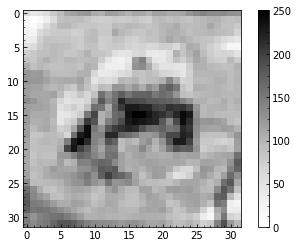

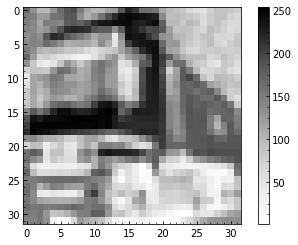

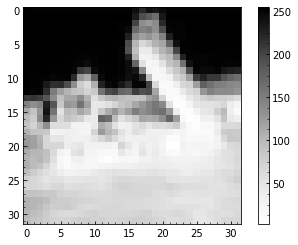

In [10]:
# extract first three images from dataset and plot, just for reference
image0 = process_cifar10_image(cifar10_batch1[b'data'][0])
image1 = process_cifar10_image(cifar10_batch1[b'data'][1])
image2 = process_cifar10_image(cifar10_batch1[b'data'][2])

show(image0)
show(image1)
show(image2)

In [11]:
# extract B/W boundaries using cutoff = 0.5 and show resulting image
cutoffs = np.arange(0.25, 0.85, 0.005)
boundary_img = []
Nb_1 = []
#img0 = Image(image0)
img2 = Image(image2)
for cutoff in cutoffs:
    bdy_img = img2.get_boundaries(cutoff)
    boundary_img.append(bdy_img)
    Nb_1.append(np.sum(bdy_img))
    print(f'cutoff: {cutoff}, Nb: {np.sum(bdy_img)}')
    #show(bdy_img)

cutoff: 0.25, Nb: 231
cutoff: 0.255, Nb: 227
cutoff: 0.26, Nb: 227
cutoff: 0.265, Nb: 227
cutoff: 0.27, Nb: 224
cutoff: 0.275, Nb: 228
cutoff: 0.28, Nb: 228
cutoff: 0.28500000000000003, Nb: 228
cutoff: 0.29000000000000004, Nb: 228
cutoff: 0.29500000000000004, Nb: 228
cutoff: 0.30000000000000004, Nb: 228
cutoff: 0.30500000000000005, Nb: 228
cutoff: 0.31000000000000005, Nb: 232
cutoff: 0.31500000000000006, Nb: 232
cutoff: 0.32000000000000006, Nb: 240
cutoff: 0.32500000000000007, Nb: 240
cutoff: 0.33000000000000007, Nb: 248
cutoff: 0.3350000000000001, Nb: 248
cutoff: 0.3400000000000001, Nb: 248
cutoff: 0.3450000000000001, Nb: 248
cutoff: 0.3500000000000001, Nb: 244
cutoff: 0.3550000000000001, Nb: 244
cutoff: 0.3600000000000001, Nb: 244
cutoff: 0.3650000000000001, Nb: 247
cutoff: 0.3700000000000001, Nb: 247
cutoff: 0.3750000000000001, Nb: 255
cutoff: 0.3800000000000001, Nb: 255
cutoff: 0.3850000000000001, Nb: 255
cutoff: 0.3900000000000001, Nb: 259
cutoff: 0.39500000000000013, Nb: 263
cuto

#### Iteratively block sample image (example)

In [21]:
# iteratively block image:
#    (64, 64) --> (32, 32) --> (16,16) --> (8, 8) --> (4, 4)
blocked1_boundary_img0 = block_image(boundary_img0)
blocked2_boundary_img0 = block_image(blocked1_boundary_img0)
blocked3_boundary_img0 = block_image(blocked2_boundary_img0)
blocked4_boundary_img0 = block_image(blocked3_boundary_img0)

(<matplotlib.figure.Figure at 0x11109bcf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1167ddb38>)

(<matplotlib.figure.Figure at 0x11109b9e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1169414e0>)

(<matplotlib.figure.Figure at 0x1167b8710>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11136b6d8>)

(<matplotlib.figure.Figure at 0x1168d08d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1166f70b8>)

(<matplotlib.figure.Figure at 0x116700d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1166b5be0>)

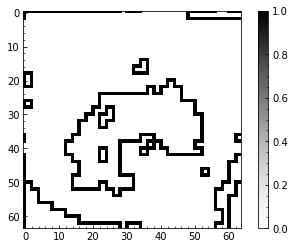

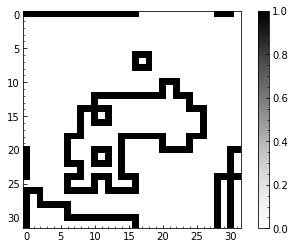

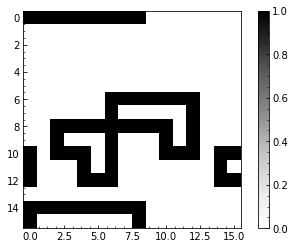

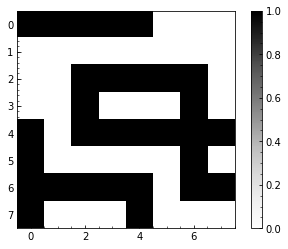

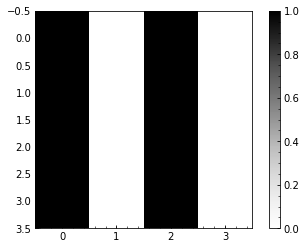

In [22]:
show(boundary_img0)
show(blocked1_boundary_img0.reshape((32,32)))
show(blocked2_boundary_img0.reshape((16,16)))
show(blocked3_boundary_img0.reshape((8,8)))
show(blocked4_boundary_img0.reshape((4,4)))

### Shuffle data and load images for analysis

In [7]:
from utils.count_bonds import CountBonds

In [8]:
# shuffle data
np.random.shuffle(cifar10_batch1[b'data'])
np.random.shuffle(cifar10_batch2[b'data'])
np.random.shuffle(cifar10_batch3[b'data'])
# select first num_sample_images from batch1 as sample data

In [9]:
num_sample_images = 200
cifar10_images0 = np.array([process_cifar10_image(img) for img in
                            cifar10_batch1[b'data'][:num_sample_images]])
cifar10_images1 = np.array([process_cifar10_image(img) for img in
                            cifar10_batch2[b'data'][:num_sample_images]])
cifar10_images2 = np.array([process_cifar10_image(img) for img in
                            cifar10_batch3[b'data'][:num_sample_images]])
print(cifar10_images0.shape)
print(cifar10_images1.shape)
print(cifar10_images2.shape)

(200, 32, 32)
(200, 32, 32)
(200, 32, 32)


### Define cutoffs and obtain boundary images

In [10]:
# create array of cutoffs for converting image to black/white pixels
#cutoffs = np.arange(0.1, 1., 0.05)
#cutoffs = [0.2, 0.3, 0.4]
cutoffs = list(np.arange(0., 1., 0.02))

cifar10_boundary_images0 = get_bdy_images(cutoffs, cifar10_images0)
cifar10_boundary_images1 = get_bdy_images(cutoffs, cifar10_images1)
cifar10_boundary_images2 = get_bdy_images(cutoffs, cifar10_images2)
print(cifar10_boundary_images0.shape)
print(cifar10_boundary_images1.shape)
print(cifar10_boundary_images2.shape)

(200, 50, 64, 64)
(200, 50, 64, 64)
(200, 50, 64, 64)


### Blocking steps

#### Block boundary images $L = 64 \rightarrow 32$

In [11]:
blocked0_boundary_images0 = block_images(cifar10_boundary_images0)
blocked0_boundary_images1 = block_images(cifar10_boundary_images1)
blocked0_boundary_images2 = block_images(cifar10_boundary_images2)
print(blocked0_boundary_images0.shape)
print(blocked0_boundary_images1.shape)
print(blocked0_boundary_images2.shape)

(200, 50, 1024)
(200, 50, 1024)
(200, 50, 1024)


#### Block again! (using blocked images from above) $ L = 32 \rightarrow 16$

In [12]:
blocked1_boundary_images0 = block_images(blocked0_boundary_images0)
blocked1_boundary_images1 = block_images(blocked0_boundary_images1)
blocked1_boundary_images2 = block_images(blocked0_boundary_images2)
print(blocked1_boundary_images0.shape)
print(blocked1_boundary_images1.shape)
print(blocked1_boundary_images2.shape)

(200, 50, 256)
(200, 50, 256)
(200, 50, 256)


#### And again! (using blocked images from above) $ L = 16 \rightarrow 8$

In [13]:
blocked2_boundary_images0 = block_images(blocked0_boundary_images0)
blocked2_boundary_images1 = block_images(blocked0_boundary_images1)
blocked2_boundary_images2 = block_images(blocked0_boundary_images2)
print(blocked2_boundary_images0.shape)
print(blocked2_boundary_images1.shape)
print(blocked2_boundary_images2.shape)

(200, 50, 256)
(200, 50, 256)
(200, 50, 256)


### Count bonds ($\langle N_b\rangle$, $\langle \Delta_{N_b}^2\rangle$)

#### Unblocked: $L = 64$

In [14]:
bond_stats0 = count_bonds_helper(cifar10_boundary_images0, num_blocks=20)
bond_stats1 = count_bonds_helper(cifar10_boundary_images1, num_blocks=20)
bond_stats2 = count_bonds_helper(cifar10_boundary_images2, num_blocks=20)

print(bond_stats0.shape)
print(bond_stats1.shape)
print(bond_stats2.shape)

(50, 4)
(50, 4)
(50, 4)


#### Blocked once: $L = 32$  

In [15]:
bond_stats0_blocked0 = count_bonds_helper(blocked0_boundary_images0, 
                                          num_blocks=20)
bond_stats1_blocked0 = count_bonds_helper(blocked0_boundary_images1, 
                                          num_blocks=20)
bond_stats2_blocked0 = count_bonds_helper(blocked0_boundary_images2, 
                                          num_blocks=20)
print(bond_stats0_blocked0.shape)
print(bond_stats1_blocked0.shape)
print(bond_stats2_blocked0.shape)

(50, 4)
(50, 4)
(50, 4)


#### Blocked twice: $L = 16$  

In [16]:
bond_stats0_blocked1 = count_bonds_helper(blocked1_boundary_images0, 
                                          num_blocks=20)
bond_stats1_blocked1 = count_bonds_helper(blocked1_boundary_images1, 
                                          num_blocks=20)
bond_stats2_blocked1 = count_bonds_helper(blocked1_boundary_images2, 
                                          num_blocks=20)
print(bond_stats0_blocked1.shape)
print(bond_stats1_blocked1.shape)
print(bond_stats2_blocked1.shape)

(50, 4)
(50, 4)
(50, 4)


#### Blocked thrice: $L = 8$  

In [ ]:
bond_stats0_blocked2 = count_bonds_helper(blocked2_boundary_images0, 
                                          num_blocks=20)
bond_stats1_blocked2 = count_bonds_helper(blocked2_boundary_images1, 
                                          num_blocks=20)
bond_stats2_blocked2 = count_bonds_helper(blocked2_boundary_images2, 
                                          num_blocks=20)
print(bond_stats0_blocked1.shape)
print(bond_stats1_blocked1.shape)
print(bond_stats2_blocked1.shape)

### OLD

In [21]:
blocked2_boundary_images0 = blocked2_boundary_images0.reshape(200, 50, 16, 16)

# swap first two axes so that each row corresponds 
# to a unique value of greyscale cutoff, across all images
blocked2_boundary_imagesT0 = np.transpose(blocked2_boundary_images0, 
                                          (1, 0, 2, 3))
#blocked2_boundary_imagesT1 = np.transpose(blocked2_boundary_images1, 
#                                          (1, 0, 2, 3))
#blocked2_boundary_imagesT2 = np.transpose(blocked2_boundary_images2, 
#                                         (1, 0, 2, 3))

bond_stats0_blocked2 = []
for cutoff_images in blocked2_boundary_imagesT0:
    count_bonds0_blocked2 = CountBonds(image_set=cutoff_images, num_blocks=20)
    bond_stats0_blocked2.append(count_bonds0_blocked2.count_bonds())
    
#bond_stats1_blocked2 = []
#for cutoff_images in blocked2_boundary_imagesT1:
#    count_bonds1_blocked2 = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats1_blocked2.append(count_bonds1_blocked2.count_bonds())
    
#bond_stats2_blocked2 = []
#for cutoff_images in blocked_boundary_imagesT2:
#    count_bonds2_blocked2 = CountBonds(image_set=cutoff_images, num_blocks=10)
#    bond_stats2_blocked2.append(count_bonds2_blocked2.count_bonds())
    
bond_stats0_blocked2 = np.array(bond_stats0_blocked2)
#bond_stats1_blocked2 = np.array(bond_stats1_blocked2)
#bond_stats2_blocked2 = np.array(bond_stats2_blocked2)

## Plots

### $\langle N_b\rangle$ vs. cutoff

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / V_{eff}$')

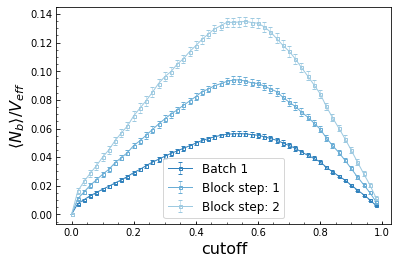

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / V_{eff}$')

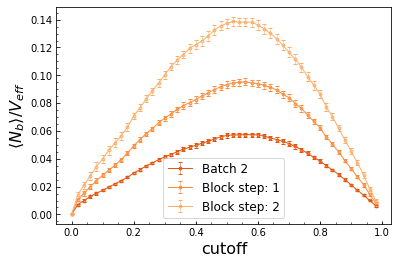

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / V_{eff}$')

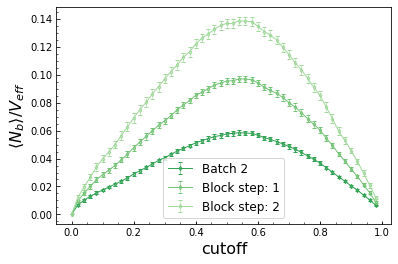

In [23]:
Nb_vals = np.array([bond_stats0[:, 0] / (64 * 64), 
                    bond_stats0_blocked0[:, 0] / (32 * 32),
                    bond_stats0_blocked1[:, 0] / (16 * 16),
                    bond_stats1[:, 0] / (64 * 64),
                    bond_stats1_blocked0[:, 0] / (32 * 32),
                    bond_stats1_blocked1[:, 0] / (16 * 16),
                    bond_stats2[:, 0] / (64 * 64),
                    bond_stats2_blocked0[:, 0] / (32 * 32),
                    bond_stats2_blocked1[:, 0] / (16 * 16)])
Nb_errs = np.array([bond_stats0[:, 1] / (64 * 64),
                    bond_stats0_blocked0[:, 1] / (32 * 32),
                    bond_stats0_blocked1[:, 1] / (16 * 16),
                    bond_stats1[:, 1] / (64 * 64),
                    bond_stats1_blocked0[:, 1] / (32 * 32),
                    bond_stats1_blocked1[:, 1] / (16 * 16),
                    bond_stats2[:, 1] / (64 * 64),
                    bond_stats2_blocked0[:, 1] / (32 * 32),
                    bond_stats2_blocked1[:, 1] / (16*16)])
Nb_xlabel = "cutoff"
Nb_ylabel = r"$\langle N_b\rangle / V_{eff}$"
Nb_values = {'x': np.array(cutoffs), 'y': Nb_vals[0], 'y_err': Nb_errs[0]}
Nb_labels = {'fig_labels': ['Batch 1', 
                            'Block step: 1', 'Block step: 2',  #'Block step: 3',
                            'Batch 2', 
                            'Block step: 1', 'Block step: 2', #'Block step: 3'],
                            'Batch 2', 
                            'Block step: 1', 'Block step: 2'],# 'Block step: 3'],
             'x_label': Nb_xlabel, 'y_label': Nb_ylabel}
limits = {'x_lim': (min(cutoffs) - 0.02, max(cutoffs) + 0.02)}
Nb_avg_plot_dir = './plots/Nb_avg/'
Nb_avg_plot_num = get_plot_num(Nb_avg_plot_dir)
Nb_avg_plot_file = (Nb_avg_plot_dir 
                    + f'Nb_avg_vs_cutoff_{Nb_avg_plot_num}.png')
#Nb_fig, Nb_ax = errorbar_plot(Nb_values, Nb_labels, Nb_avg_plot_file, 
#                              limits, markersize=3.5)
cc = [0, 4, 8, 12]
for idx, i in enumerate(range(2, len(Nb_vals), 3)):
    #for idx, i in enumerate(range(len(Nb_vals))):
    fig, ax = plt.subplots()
    ax.errorbar(cutoffs, Nb_vals[i-2], yerr=Nb_errs[i-2],
                label=Nb_labels['fig_labels'][i-2], 
                marker=markers[(i-2) // 3],
                #marker=markers[(i-3) // 4],
                markersize=3, fillstyle='none',
                #color=colors[(i-2) // 3], 
                color=cm.tab20c(0 + cc[(i-2) //3]),
                #color=cm.coolwarm_r(10),
                #markeredgecolor=cm.coolwarm_r(0),
                #markeredgecolor=markeredgecolors[(i-2) // 3],
                ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
    ax.errorbar(cutoffs, Nb_vals[i-1], yerr=Nb_errs[i-1],
                label=Nb_labels['fig_labels'][i-1], 
                #marker=markers[(i-2) // 3],
                marker=markers[(i-2) // 3],
                markersize=3, fillstyle='none',
                color=cm.tab20c(1 + cc[(i-2) // 3]),
                #color=colors[(i-2) // 3], 
                #color=cm.coolwarm_r(30),
                #markeredgecolor=cm.coolwarm_r(20),
                #markeredgecolor=markeredgecolors[(i-2) // 3],
                ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
    ax.errorbar(cutoffs, Nb_vals[i], yerr=Nb_errs[i],
                label=Nb_labels['fig_labels'][i], 
                marker=markers[(i-2) // 3],
                markersize=3, fillstyle='none',
                color=cm.tab20c(2 + cc[(i-2) // 3]),
                #color=colors[(i-2) // 3], 
                #color=cm.tab20c(1 + cc[2]),
                #color=cm.coolwarm_r(50),
                #markeredgecolor=cm.coolwarm_r(40),
                #markeredgecolor=markeredgecolors[(i-2) // 3],
                ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
    #ax.errorbar(cutoffs, Nb_vals[3], yerr=Nb_errs[3],
    #            label=Nb_labels['fig_labels'][3], 
    #            #marker=markers[(i-2) // 3],
    #            marker=markers[0],
    #            markersize=3, fillstyle='none',
    #            color=cm.tab20c(3 + cc[2]),
    #            #color=colors[(i-2) // 3], 
    #            #color=cm.tab20c(2 + cc[2]),
    #            #color=cm.coolwarm_r(70),
    #            #markeredgecolor=cm.coolwarm_r(60),
    #            #markeredgecolor=markeredgecolors[(i-2) // 3],
    #            ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
    leg = ax.legend(loc='best', markerscale=1., fontsize=12)
    ax.set_xlabel(Nb_labels['x_label'], fontsize=16)
    ax.set_ylabel(Nb_labels['y_label'], fontsize=16)
    Nb_avg_plot_num = get_plot_num(Nb_avg_plot_dir)
    Nb_avg_plot_file = (Nb_avg_plot_dir 
                        + f'Nb_avg_vs_cutoff_{Nb_avg_plot_num}.png')
    fig.savefig(Nb_avg_plot_file, dpi=400, bbox_inches='tight')
    plt.show()

    #fig.savefig(Nb_avg_plot_file, dpi=400, bbox_inches='tight')

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / V_{eff}$')

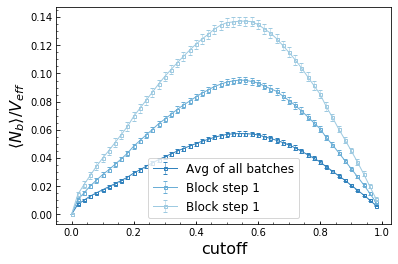

In [25]:
bond_stats_avg = ((bond_stats0 + bond_stats1 + bond_stats2) / 3) / (64 * 64)
bond_stats_avg_blocked = ((bond_stats0_blocked0 
                          + bond_stats1_blocked0 
                          + bond_stats2_blocked0) / 3) / (32 * 32)
bond_stats_avg_blocked1 = ((bond_stats0_blocked1 
                           + bond_stats1_blocked1 
                           + bond_stats2_blocked1) / 3) / (16 * 16)

fig, ax = plt.subplots()
ax.errorbar(cutoffs, bond_stats_avg[:,0], yerr=bond_stats_avg[:,1],
            label='Avg of all batches', marker=markers[0], markersize=3,
            fillstyle='none', color=cm.tab20c(0 + cc[0]), ls='-', lw=1.,
            elinewidth=0.5, capsize=2., capthick=1.)
ax.errorbar(cutoffs, bond_stats_avg_blocked[:,0], 
            yerr=bond_stats_avg_blocked[:,1],
            label='Block step 1', marker=markers[0], markersize=3,
            fillstyle='none', color=cm.tab20c(1 + cc[0]), ls='-', lw=1.,
            elinewidth=0.5, capsize=2., capthick=1.)
ax.errorbar(cutoffs, bond_stats_avg_blocked1[:,0], 
            yerr=bond_stats_avg_blocked1[:,1],
            label='Block step 1', marker=markers[0], markersize=3,
            fillstyle='none', color=cm.tab20c(2 + cc[0]), ls='-', lw=1.,
            elinewidth=0.5, capsize=2., capthick=1.)
leg = ax.legend(loc='best', markerscale=1, fontsize=12)
ax.set_xlabel(Nb_labels['x_label'], fontsize=16)
ax.set_ylabel(Nb_labels['y_label'], fontsize=16)
Nb_avg_plot_num = get_plot_num(Nb_avg_plot_dir)
Nb_avg_plot_file = (Nb_avg_plot_dir 
                    + f'Nb_avg_vs_cutoff_averaged_{Nb_avg_plot_num}.png')
fig.savefig(Nb_avg_plot_file, dpi=400, bbox_inches='tight')
plt.show()

### $\langle \Delta_{N_b}^2\rangle$ vs. cutoff

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle/ V_{eff} ^ {2}$')

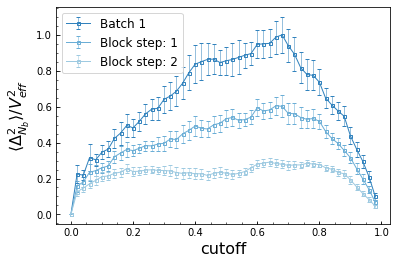

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle/ V_{eff} ^ {2}$')

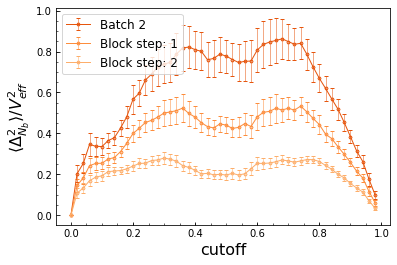

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle/ V_{eff} ^ {2}$')

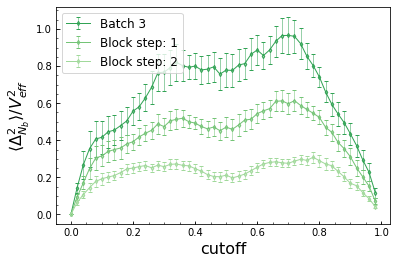

In [27]:
#bond_stats0 = np.array(bond_stats0)
#bond_stats0_blocked = np.array(bond_stats0_blocked)

#markers = ['s', 'H', 'd', 'v', 'p', 'P']
#colors = ['#2A9Df8', '#FF920B', '#65e41d', '#be67ff', '#ff7e79', '#959595']
#markeredgecolors = ['#0256a3', '#ed4c18',  '#00B000', '#6633cc',
#                    '#ee2324','#1c2022']
bond_stats0_blocked1 = np.array(bond_stats0_blocked1)
bond_stats1_blocked1 = np.array(bond_stats1_blocked1)
bond_stats2_blocked1 = np.array(bond_stats2_blocked1)
volume_arr = np.array([64*64, 32*32, 16*16], dtype=np.float64)
volume_scale = 2
volume_arr *= volume_scale


delta_Nb_vals = np.array([bond_stats0[:, 2] / volume_arr[0], 
                          bond_stats0_blocked0[:, 2] / volume_arr[1],
                          bond_stats0_blocked1[:, 2] / volume_arr[2],
                          #bond_stats0_blocked2[:, 2] / (8 * 8)])
                          bond_stats1[:, 2] / volume_arr[0], 
                          bond_stats1_blocked0[:, 2] / volume_arr[1],
                          bond_stats1_blocked1[:, 2] / volume_arr[2],
                          #bond_stats1_blocked2[:, 2] / (8 * 8),
                          bond_stats2[:, 2] /volume_arr[0], 
                          bond_stats2_blocked0[:, 2] /volume_arr[1],
                          bond_stats2_blocked1[:, 2] / volume_arr[2]])
                          #bond_stats2_blocked2[:, 2] / (8 * 8)])
delta_Nb_errs = np.array([bond_stats0[:, 3] / volume_arr[0],
                          bond_stats0_blocked0[:, 3] / volume_arr[1],
                          bond_stats0_blocked1[:, 3] / volume_arr[2],
                          #bond_stats0_blocked2[:, 3] / (8 * 8)])
                          bond_stats1[:, 3] / volume_arr[0],
                          bond_stats1_blocked0[:, 3] / volume_arr[1],
                          bond_stats1_blocked1[:, 3] / volume_arr[2],
                          #bond_stats1_blocked2[:, 3] / (8 * 8),
                          bond_stats2[:, 3] / volume_arr[0],
                          bond_stats2_blocked0[:, 3] / volume_arr[1],
                          bond_stats2_blocked1[:, 3] / volume_arr[2]])
                          #bond_stats2_blocked2[:, 3] / (8 * 8)])
delta_Nb_xlabel = "cutoff"
delta_Nb_ylabel = r"$\langle \Delta_{N_b}^2\rangle/ V_{eff} ^ {2}$" # DON'T FORGET TO CHANGE
delta_Nb_values = {'x': np.array(cutoffs), 'y': Nb_vals[0], 'y_err': Nb_errs[0]}
delta_Nb_labels = {'fig_labels': ['Batch 1', 
                                  'Block step: 1', 'Block step: 2', #'Block step: 3']
                                  'Batch 2', 
                                  'Block step: 1', 'Block step: 2', #'Block step 3',
                                  'Batch 3', 
                                  'Block step: 1', 'Block step: 2'], #'Block step 3'],
                   'x_label': delta_Nb_xlabel, 'y_label': delta_Nb_ylabel}
limits = {'x_lim': (min(cutoffs) - 0.02, max(cutoffs) + 0.02)}
delta_Nb_plot_dir = './plots/delta_Nb/'
#delta_Nb_plot_num = get_plot_num(delta_Nb_plot_dir)
#delta_Nb_plot_file = (delta_Nb_plot_dir 
#                    + f'delta_Nb_vs_cutoff_{delta_Nb_plot_num}.png')
#Nb_fig, Nb_ax = errorbar_plot(Nb_values, Nb_labels, Nb_avg_plot_file, 
#                              limits, markersize=3.5)

                          
cc = [0, 4, 8, 12]
for (idx, i) in enumerate(range(2, len(delta_Nb_vals), 3)):
    fig, ax = plt.subplots()
    ax.errorbar(cutoffs, delta_Nb_vals[i-2], yerr=delta_Nb_errs[i-2],
                label=delta_Nb_labels['fig_labels'][i-2], 
                marker=markers[(i-2)//3],
                markersize=3, fillstyle='none',
                color=cm.tab20c(0 + cc[(i-2)//3]),
                #color=colors[i-1], 
                #markeredgecolor=markeredgecolors[i-1],
                ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
    ax.errorbar(cutoffs, delta_Nb_vals[i-1], yerr=delta_Nb_errs[i-1],
                label=delta_Nb_labels['fig_labels'][i-1], 
                marker=markers[(i-2)//3],
                markersize=3, fillstyle='none',
                color=cm.tab20c(1 + cc[(i-2)//3]),
                #color=colors[i-1], 
                #markeredgecolor=markeredgecolors[i-1],
                ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
    ax.errorbar(cutoffs, delta_Nb_vals[i], yerr=delta_Nb_errs[i],
                label=delta_Nb_labels['fig_labels'][i], 
                marker=markers[(i-2)//3],
                markersize=3, fillstyle='none',
                color=cm.tab20c(2 + cc[(i-2)//3]),
                #color=colors[i-1], markeredgecolor=markeredgecolors[i-1],
                ls='-', lw=1., elinewidth=0.5, capsize=2., capthick=1.)
    #ax.errorbar(cutoffs, delta_Nb_vals[3], yerr=delta_Nb_errs[3],
    #            label=Nb_labels['fig_labels'][3], 
    #            marker=markers[0],
    #            markersize=3, fillstyle='none',
    #            color=cm.tab20c(3 + cc[2]),
    #            #color=colors[i-1], markeredgecolor=markeredgecolors[i-1],
    #            ls='-', lw=1., elinewidth=1., capsize=2., capthick=2.)
    leg = ax.legend(loc='best', markerscale=1, fontsize=12)
    ax.set_xlabel(delta_Nb_labels['x_label'], fontsize=16)
    ax.set_ylabel(delta_Nb_labels['y_label'], fontsize=16)
    delta_Nb_plot_num = get_plot_num(delta_Nb_plot_dir)
    delta_Nb_plot_file = (delta_Nb_plot_dir 
                        + f'delta_Nb_vs_cutoff_{delta_Nb_plot_num}.png')
    fig.savefig(delta_Nb_plot_file, dpi=400, bbox_inches='tight')
    plt.show()
    #fig.savefig(Nb_avg_plot_file, dpi=400, bbox_inches='tight')

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle/ V_{eff} ^ {2}$')

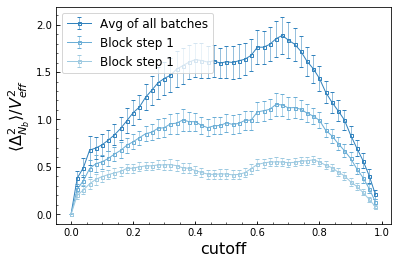

In [28]:
fig, ax = plt.subplots()
ax.errorbar(cutoffs, bond_stats_avg[:,2], yerr=bond_stats_avg[:,3],
            label='Avg of all batches', marker=markers[0], markersize=3,
            fillstyle='none', color=cm.tab20c(0 + cc[0]), ls='-', lw=1.,
            elinewidth=0.5, capsize=2., capthick=1.)
ax.errorbar(cutoffs, bond_stats_avg_blocked[:,2], 
            yerr=bond_stats_avg_blocked[:,3],
            label='Block step 1', marker=markers[0], markersize=3,
            fillstyle='none', color=cm.tab20c(1 + cc[0]), ls='-', lw=1.,
            elinewidth=0.5, capsize=2., capthick=1.)
ax.errorbar(cutoffs, bond_stats_avg_blocked1[:,2], 
            yerr=bond_stats_avg_blocked1[:,3],
            label='Block step 1', marker=markers[0], markersize=3,
            fillstyle='none', color=cm.tab20c(2 + cc[0]), ls='-', lw=1.,
            elinewidth=0.5, capsize=2., capthick=1.)
leg = ax.legend(loc='best', markerscale=1, fontsize=12)
ax.set_xlabel(delta_Nb_labels['x_label'], fontsize=16)
ax.set_ylabel(delta_Nb_labels['y_label'], fontsize=16)
delta_Nb_plot_num = get_plot_num(delta_Nb_plot_dir)
delta_Nb_plot_file = (delta_Nb_plot_dir 
                    + f'delta_Nb_vs_cutoff_avg_{delta_Nb_plot_num}.png')
fig.savefig(delta_Nb_plot_file, dpi=400, bbox_inches='tight')
plt.show()

### Plot $\langle N_b\rangle / \langle N_b^{\text{blocked}}\rangle$ vs. cutoff

#### Batch 0

In [74]:
Nb0_ratio_01 = ((bond_stats0[1:, 0]/(64*64)) / (bond_stats0_blocked0[1:, 0]/(32*32)))
Nb0_ratio_01_errs = ((bond_stats0[1:, 1]/(64*64)) + (bond_stats0_blocked0[1:, 1]/(32*32))) /2

Nb0_ratio_12 = ((bond_stats0_blocked0[1:, 0]/(32*32)) / (bond_stats0_blocked1[1:, 0]/(16*16)))
Nb0_ratio_12_errs = ((bond_stats0_blocked0[1:, 1]/(32*32)) + (bond_stats0_blocked1[1:, 1]/(16*16))) / 2

Nb0_ratio_02 = ((bond_stats0[1:, 0]/(64*64)) / (bond_stats0_blocked1[1:, 0]/(16*16)))
Nb0_ratio_02_errs = ((bond_stats0[1:, 1]/(64*64)) + (bond_stats0_blocked1[1:, 1]/(16*16))) / 2

Nb0_ratio_23 = ((bond_stats0_blocked1[1:, 0]/(16*16)) / (bond_stats0_blocked2[1:, 0]/(8*8)))
Nb0_ratio_23_errs = ((bond_stats0_blocked1[1:, 1]/(16*16)) + (bond_stats0_blocked2[1:, 1]/(8*8))) / 2

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / \\langle N_b^{blocked}\\rangle$')

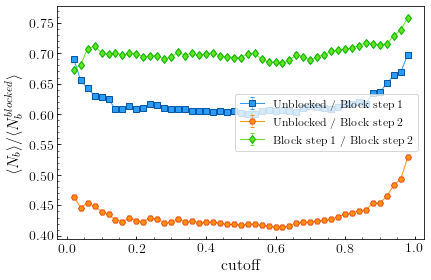

In [88]:
fig, ax = plt.subplots()
ax.errorbar(cutoffs[1:], Nb0_ratio_01, yerr=bond_stats0[1:,1]/(64*64), 
            marker=markers[0], ls='-', lw=1.,
            color=colors[0], markeredgecolor=markeredgecolors[0],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Unblocked / Block step 1')
ax.errorbar(cutoffs[1:], Nb0_ratio_02, yerr=bond_stats0[1:, 1] / (64*64),
            marker=markers[1], ls='-', lw=1., 
            color=colors[1], markeredgecolor=markeredgecolors[1],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Unblocked / Block step 2')
ax.errorbar(cutoffs[1:], Nb0_ratio_12, yerr=bond_stats0_blocked1[1:, 1]/(16*16),
            marker=markers[2], ls='-', lw=1., 
            color=colors[2], markeredgecolor=markeredgecolors[2],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Block step 1 / Block step 2')
ax.set_xlabel("cutoff", fontsize=16)
ax.set_ylabel(r"$\langle N_b\rangle / \langle N_b^{blocked}\rangle$", fontsize=16)
ax.legend(loc='best', markerscale=1., fontsize=12)
fig.tight_layout()
fig.savefig('./plots/Nb_ratio_vs_cutoff_0.png', dpi=400, bbox_imches='tight')

#### Batch 1

In [89]:
Nb1_ratio_01 = ((bond_stats1[1:, 0]/(64*64)) / (bond_stats1_blocked0[1:, 0]/(32*32)))
Nb1_ratio_01_errs = ((bond_stats1[1:, 1]/(64*64)) / (bond_stats1_blocked0[1:, 1]/(32*32)))

Nb1_ratio_12 = ((bond_stats1_blocked0[1:, 0]/(32*32)) / (bond_stats1_blocked1[1:, 0]/(16*16)))
Nb1_ratio_12_errs = ((bond_stats1_blocked0[1:, 1]/(32*32)) / (bond_stats1_blocked1[1:, 1]/(16*16)))

Nb1_ratio_02 = ((bond_stats1[1:, 0]/(64*64)) / (bond_stats1_blocked1[1:, 0]/(16*16)))
Nb1_ratio_02_errs = ((bond_stats1[1:, 1]/(64*64)) / (bond_stats1_blocked1[1:, 1]/(16*16)))

Nb1_ratio_23 = ((bond_stats1_blocked1[1:, 0]/(16*16)) / (bond_stats1_blocked2[1:, 0]/(8*8)))
Nb1_ratio_23_errs = ((bond_stats1_blocked1[1:, 1]/(16*16)) / (bond_stats1_blocked2[1:, 1]/(8*8)))

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / \\langle N_b^{blocked}\\rangle$')

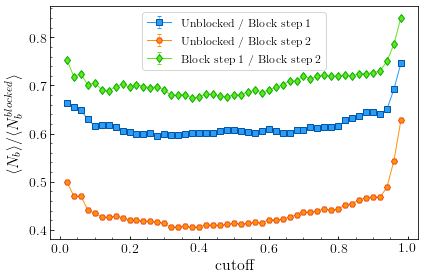

In [90]:
fig, ax = plt.subplots()
ax.errorbar(cutoffs[1:], Nb1_ratio_01, yerr=bond_stats1[1:,1]/(64*64), 
            marker=markers[0], ls='-', lw=1.,
            color=colors[0], markeredgecolor=markeredgecolors[0],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Unblocked / Block step 1')
ax.errorbar(cutoffs[1:], Nb1_ratio_02, yerr=bond_stats1[1:, 1] / (64*64),
            marker=markers[1], ls='-', lw=1., 
            color=colors[1], markeredgecolor=markeredgecolors[1],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Unblocked / Block step 2')
ax.errorbar(cutoffs[1:], Nb1_ratio_12, yerr=bond_stats1_blocked1[1:, 1]/(16*16),
            marker=markers[2], ls='-', lw=1., 
            color=colors[2], markeredgecolor=markeredgecolors[2],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Block step 1 / Block step 2')
ax.set_xlabel("cutoff", fontsize=16)
ax.set_ylabel(r"$\langle N_b\rangle / \langle N_b^{blocked}\rangle$", fontsize=16)
ax.legend(loc='best', markerscale=1., fontsize=12)
fig.tight_layout()
fig.savefig('./plots/Nb_ratio_vs_cutoff_1.png', dpi=400, bbox_imches='tight')

#### Batch 2

In [91]:
Nb2_ratio_01 = ((bond_stats2[1:, 0]/(64*64)) / (bond_stats2_blocked0[1:, 0]/(32*32)))
Nb2_ratio_01_errs = ((bond_stats2[1:, 1]/(64*64)) / (bond_stats2_blocked0[1:, 1]/(32*32)))

Nb2_ratio_12 = ((bond_stats2_blocked0[1:, 0]/(32*32)) / (bond_stats2_blocked1[1:, 0]/(16*16)))
Nb2_ratio_12_errs = ((bond_stats2_blocked0[1:, 1]/(32*32)) / (bond_stats2_blocked1[1:, 1]/(16*16)))

Nb2_ratio_02 = ((bond_stats2[1:, 0]/(64*64)) / (bond_stats2_blocked1[1:, 0]/(16*16)))
Nb2_ratio_02_errs = ((bond_stats2[1:, 1]/(64*64)) / (bond_stats2_blocked1[1:, 1]/(16*16)))

Nb2_ratio_23 = ((bond_stats2_blocked1[1:, 0]/(16*16)) / (bond_stats2_blocked2[1:, 0]/(8*8)))
Nb2_ratio_23_errs = ((bond_stats2_blocked1[1:, 1]/(16*16)) / (bond_stats2_blocked2[1:, 1]/(8*8)))

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / \\langle N_b^{blocked}\\rangle$')

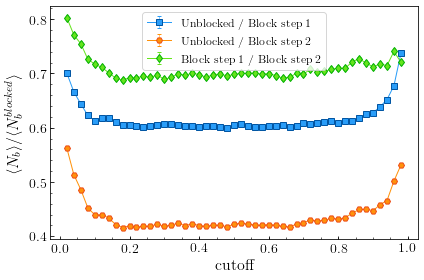

In [92]:
fig, ax = plt.subplots()
ax.errorbar(cutoffs[1:], Nb2_ratio_01, yerr=bond_stats2[1:,1]/(64*64), 
            marker=markers[0], ls='-', lw=1.,
            color=colors[0], markeredgecolor=markeredgecolors[0],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Unblocked / Block step 1')
ax.errorbar(cutoffs[1:], Nb2_ratio_02, yerr=bond_stats2[1:, 1] / (64*64),
            marker=markers[1], ls='-', lw=1., 
            color=colors[1], markeredgecolor=markeredgecolors[1],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Unblocked / Block step 2')
ax.errorbar(cutoffs[1:], Nb2_ratio_12, yerr=bond_stats2_blocked1[1:, 1]/(16*16),
            marker=markers[2], ls='-', lw=1., 
            color=colors[2], markeredgecolor=markeredgecolors[2],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Block step 1 / Block step 2')
ax.set_xlabel("cutoff", fontsize=16)
ax.set_ylabel(r"$\langle N_b\rangle / \langle N_b^{blocked}\rangle$", fontsize=16)
ax.legend(loc='best', markerscale=1., fontsize=12)
fig.tight_layout()
fig.savefig('./plots/Nb_ratio_vs_cutoff_2.png', dpi=400, bbox_imches='tight')

#### Average over all three batches

In [93]:
Nb_ratio_01_avg = (Nb0_ratio_01 + Nb1_ratio_01 + Nb2_ratio_01) / 3
Nb_ratio_02_avg = (Nb0_ratio_02 + Nb1_ratio_02 + Nb2_ratio_02) / 3
Nb_ratio_12_avg = (Nb0_ratio_12 + Nb1_ratio_12 + Nb2_ratio_12) / 3
Nb_ratio_23_avg = (Nb0_ratio_23 + Nb1_ratio_23 + Nb2_ratio_23) / 3

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'cutoff')

Text(0,0.5,'$\\langle N_b\\rangle / \\langle N_b^{blocked}\\rangle$')

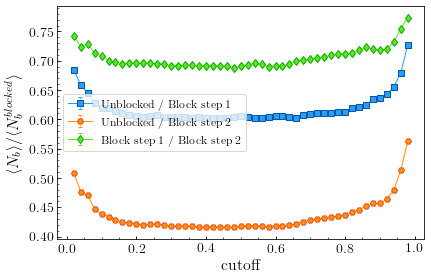

In [96]:
fig, ax = plt.subplots()
ax.errorbar(cutoffs[1:], Nb_ratio_01_avg, yerr=bond_stats2[1:,1]/(64*64), 
            marker=markers[0], ls='-', lw=1.,
            color=colors[0], markeredgecolor=markeredgecolors[0],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Unblocked / Block step 1')
ax.errorbar(cutoffs[1:], Nb_ratio_02_avg, yerr=bond_stats2[1:, 1] / (64*64),
            marker=markers[1], ls='-', lw=1., 
            color=colors[1], markeredgecolor=markeredgecolors[1],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Unblocked / Block step 2')
ax.errorbar(cutoffs[1:], Nb_ratio_12_avg, yerr=bond_stats2_blocked1[1:, 1]/(16*16),
            marker=markers[2], ls='-', lw=1., 
            color=colors[2], markeredgecolor=markeredgecolors[2],
            elinewidth=0.5, capsize=2., capthick=1.,
            label='Block step 1 / Block step 2')
ax.set_xlabel("cutoff", fontsize=16)
ax.set_ylabel(r"$\langle N_b\rangle / \langle N_b^{blocked}\rangle$", fontsize=16)
ax.legend(loc='best', markerscale=1., fontsize=12)
fig.tight_layout()
fig.savefig('./plots/Nb_ratio_vs_cutoff_avg_0.png', dpi=400, bbox_inches='tight')